In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
!pip install seaborn --upgrade
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics

In [2]:
# Import the database
df = pd.read_csv('diabetes_data_upload.csv')

In [3]:
df.head(5)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


Let's check if there is missing values

In [4]:
df.isnull().sum()

Age                   0
Gender                0
Polyuria              0
Polydipsia            0
sudden weight loss    0
weakness              0
Polyphagia            0
Genital thrush        0
visual blurring       0
Itching               0
Irritability          0
delayed healing       0
partial paresis       0
muscle stiffness      0
Alopecia              0
Obesity               0
class                 0
dtype: int64

Let's encode the categorical variables

In [5]:
df_encoded = df.replace({'Yes': 1, 'No': 0, 'Positive': 1, 'Negative': 0, 'Male': 1, 'Female': 0})

In [6]:
df_encoded.head(5)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


Let's try some data exploration now to see if we can find some links between the features

<function matplotlib.pyplot.show(close=None, block=None)>

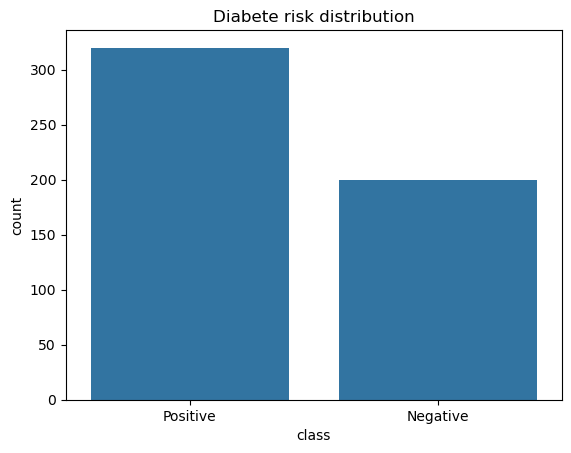

In [7]:
sns.countplot(x='class', data = df)
plt.title('Diabete risk distribution')
plt.show

The dataset is not really balanced, for the feature we are trying to classify our dataset is biased toward people that are positive for diabetes.
We might want to use something more than precision for model evaluation later on.

## Correlation Heatmap

Let's check the relationship between variables with a correlation heatmap :

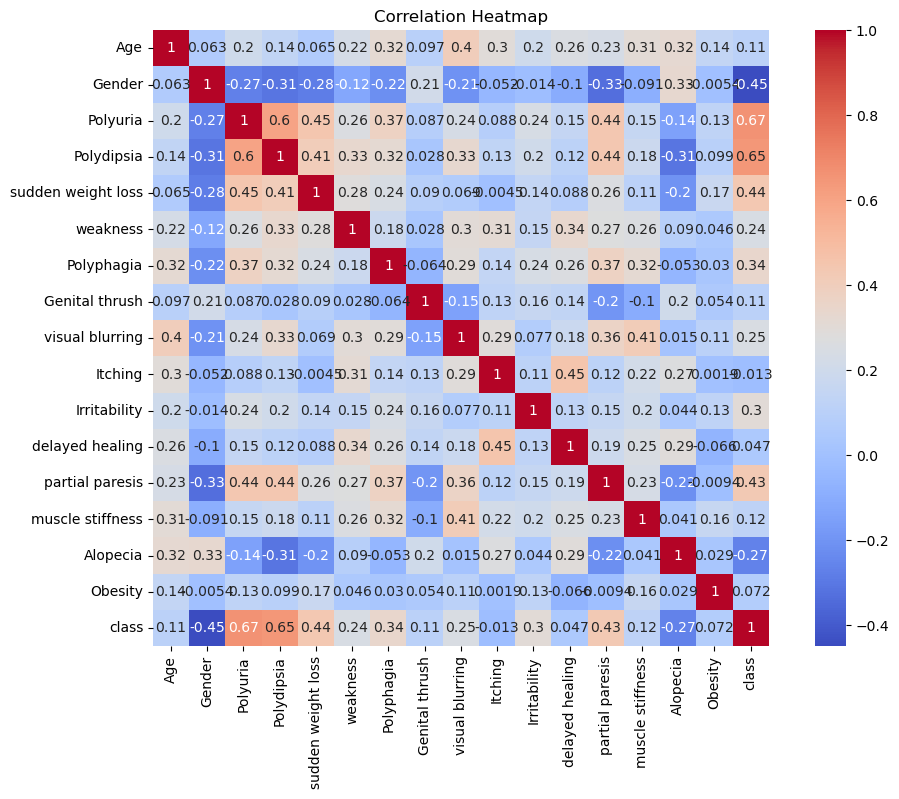

In [8]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', square = True)
plt.title('Correlation Heatmap')
plt.show()

There's some clear outlier that seem to have a high impact on the future classification. Polyuria and Polydipsia seems to have a positive influence over having diabete, but it can be that diabetese create these diseases, and not the other way around. As these 2 values have the coefficient that is the biggest, we can suspect that they are the features that will have the most impact on the classification.

The gender would indicates that when its value increase, from 0 to 1 (from male to female as we switched earlier), the likelihood of getting a 1 in class (positive), decrease. So according to this correlation heatmap, female are more likely to have diabetes.

## Decision Tree

Let's try the classification of diabetes with a Decision Tree

In [9]:
features = []
for column in df_encoded.columns:
    if column != "class":
        features.append(column)
print(features)

['Age', 'Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss', 'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring', 'Itching', 'Irritability', 'delayed healing', 'partial paresis', 'muscle stiffness', 'Alopecia', 'Obesity']


In [10]:
X = df_encoded[features]
Y = df_encoded['class']

Let's split the data to train our model

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1)

Now we can fit the model to our training batch

In [12]:
dtree = DecisionTreeClassifier()

In [13]:
dtree = dtree.fit(X_train, Y_train)

We can now try our model on the test batch

In [14]:
Y_pred = dtree.predict(X_test)

In [15]:
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))

Accuracy: 0.9807692307692307


We have a pretty good accuracy, but as seen earlier as our dataset is biased toward a positive diagnostic, let's check other metrics.

In [27]:
from sklearn.metrics import classification_report
class_report = classification_report(Y_test, Y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        58
           1       0.97      1.00      0.98        98

    accuracy                           0.98       156
   macro avg       0.99      0.97      0.98       156
weighted avg       0.98      0.98      0.98       156



The overall metrics of the classifier are really good, but we can see that what we supposed earlier, that the model is biased toward positive diagnostic.
Indeed, he predicted correctly all the positive patient, but missed a few for the negative ones.

Let's integrate cross validation to be sure that our result isn't just because we got lucky by splitting our dataset

In [34]:
from sklearn.model_selection import cross_validate
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
cv_results = cross_validate(dtree, X, Y, cv = 5, scoring = scoring)

In [35]:
print(f"Mean Accuracy: {cv_results['test_accuracy'].mean():.2f}")
print(f"Mean Precision: {cv_results['test_precision_macro'].mean():.2f}")
print(f"Mean Recall: {cv_results['test_recall_macro'].mean():.2f}")
print(f"Mean F1: {cv_results['test_f1_macro'].mean():.2f}")

Mean Accuracy: 0.96
Mean Precision: 0.96
Mean Recall: 0.96
Mean F1: 0.96


We have a little less good results as the first model, but now we are sure that our model is consistent and we didn't just hit the jackpot on the first split.

### Visualization of the Tree

Let's try to visualize the decision tree :

In [18]:
from sklearn.datasets import load_iris
from sklearn import tree

[Text(0.6363636363636364, 0.9, 'Polydipsia <= 0.5\ngini = 0.476\nsamples = 364\nvalue = [142, 222]'),
 Text(0.36363636363636365, 0.7, 'Polyuria <= 0.5\ngini = 0.438\nsamples = 204\nvalue = [138, 66]'),
 Text(0.18181818181818182, 0.5, 'Gender <= 0.5\ngini = 0.318\nsamples = 156\nvalue = [125, 31]'),
 Text(0.09090909090909091, 0.3, 'Alopecia <= 0.5\ngini = 0.478\nsamples = 33\nvalue = [13, 20]'),
 Text(0.045454545454545456, 0.1, '\n  (...)  \n'),
 Text(0.13636363636363635, 0.1, '\n  (...)  \n'),
 Text(0.2727272727272727, 0.3, 'Irritability <= 0.5\ngini = 0.163\nsamples = 123\nvalue = [112, 11]'),
 Text(0.22727272727272727, 0.1, '\n  (...)  \n'),
 Text(0.3181818181818182, 0.1, '\n  (...)  \n'),
 Text(0.5454545454545454, 0.5, 'Age <= 63.5\ngini = 0.395\nsamples = 48\nvalue = [13, 35]'),
 Text(0.45454545454545453, 0.3, 'Obesity <= 0.5\ngini = 0.161\nsamples = 34\nvalue = [3, 31]'),
 Text(0.4090909090909091, 0.1, '\n  (...)  \n'),
 Text(0.5, 0.1, '\n  (...)  \n'),
 Text(0.6363636363636364, 0

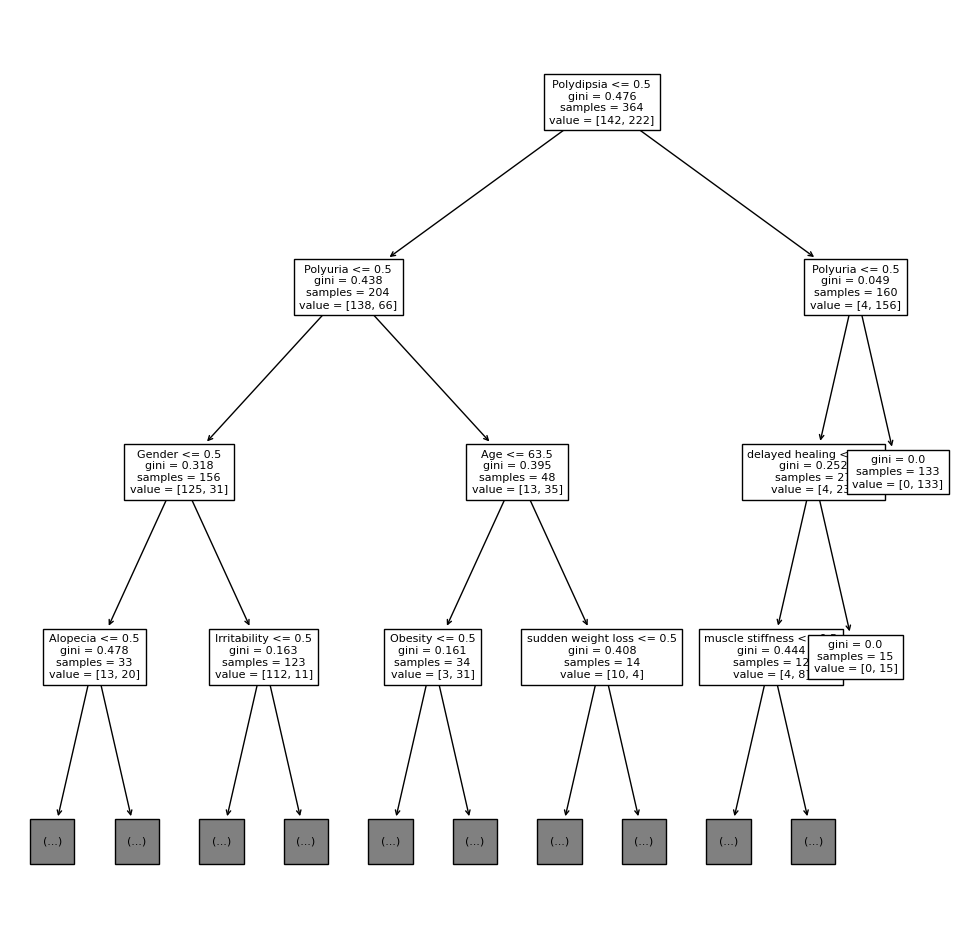

In [31]:
iris = load_iris()
plt.figure(figsize=(12,12))
tree.plot_tree(dtree, feature_names = features, fontsize = 8, max_depth = 3)

We can't show the whole tree as it is too big, but we can see the start and first steps of decision used by the model.

The first 2 features chosen by the model for the steps are the Polydipsia and Polyuria, meaning it is the 2 features that have the most impact on the classification, as we expected with the correlation heatmap

## Random forest